In [2]:
# Unzip the file
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

In [3]:
# Import All Nesessary Libraries
import os, random, gc, math, time
import numpy as np
import pandas as pd

import cv2
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import keras_preprocessing.image
import keras.backend as k
from keras.applications import VGG16, VGG19
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.layers import BatchNormalization, Dense, Dropout, Flatten
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, LeakyReLU
from keras.layers import Input, AvgPool2D, Conv2D
from keras.layers import multiply, concatenate, Lambda, Reshape
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import metrics
from keras.utils.vis_utils import plot_model


from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.utils import class_weight


# Configuration
%matplotlib inline


Using TensorFlow backend.


In [0]:
# Specifying the Training Parameters

is_pretrained = True
keep_training = True # Adam -> SGD
batch_size = 39
width = 150
height = 150
learning_rate = 1e-4
batch_size = 64
epochs = 10

In [0]:

def dir_file_count(directory):
  total_files = 0
  for root, dirs, files in os.walk(".", topdown=False):
    total_files += len(list(filter(lambda x: x.endswith('.jpeg'), files)))
  return total_files

def xray_process(im):
  # X-Rays are negative images. Imagenet was trained on normal images.
  im = 255. - im

  # Imagenet tensorflow samples are scaled between -1 (black) and 1 (white)
  # https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
  im /= 255.
  im -= .5
  im *= 2.
  return im

In [0]:
# Defining Paths

target_size = (height, width)
class_mode = 'categorical'
training_dir = 'chest_xray/train'
testing_dir = 'chest_xray/test'
proj_dir = 'temp'
# Creating Directories to Store Models
!mkdir temp/
!mkdir temp/models
!mkdir images

In [7]:
# TrainSet Preparation
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=xray_process)

train_generator = train_datagen.flow_from_directory(training_dir,
                                                    target_size=target_size,
                                                    interpolation='lanczos',
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)

Found 5216 images belonging to 2 classes.


In [8]:
# TestSet Preparation
test_datagen = ImageDataGenerator(
                                  fill_mode='nearest',
                                  preprocessing_function=xray_process)

test_generator = test_datagen.flow_from_directory(testing_dir,
                                                  target_size=target_size,
                                                  interpolation='lanczos',
                                                  class_mode=class_mode,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 624 images belonging to 2 classes.


In [9]:
def get_weight(y):
    class_weight_current = class_weight.compute_class_weight('balanced',
                                                             np.unique(y), y)
    return class_weight_current

class_w = get_weight(train_generator.classes)
print(class_w)

[1.9448173  0.67303226]


In [0]:
def get_image_set(image_set, image_type):
  def get_image_path(path_pre, image_name):
    return '{}/{}/{}/{}'.format(path_pre, image_set, image_type, image_name)

  path_pre = './chest_xray'
  image_list = os.listdir('{}/{}/{}'.format(path_pre, image_set, image_type))
  image_list = list(map(lambda x: get_image_path(path_pre, x), image_list))

  # Ignore .DS_Store files
  image_list = list(filter(lambda x: x.endswith('.jpeg'), image_list))
  return image_list

tr_normal = get_image_set('train', 'NORMAL')
tr_pneumonia = get_image_set('train', 'PNEUMONIA')

te_normal = get_image_set('test', 'NORMAL')
te_pneumonia = get_image_set('test', 'PNEUMONIA')

images_normal = tr_normal + te_normal
images_pneumonia = tr_pneumonia + te_pneumonia
images_pneumonia_bacterial = [img for img in images_pneumonia
                              if img.split('/')[-1].split('_')[1] == 'bacteria']
images_pneumonia_viral = [img for img in images_pneumonia
                          if img.split('/')[-1].split('_')[1] == 'virus']

images_full = images_normal + images_pneumonia
images_test = te_normal + te_pneumonia

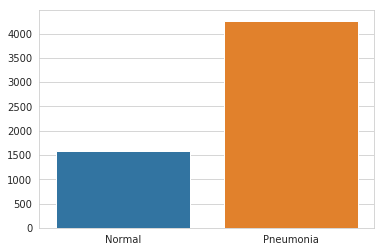

In [11]:
# Plotting the count of Patient Types
sns.set_style('whitegrid')
sns.barplot(x=['Normal', 'Pneumonia'],
            y=[len(images_normal),
               len(images_pneumonia)])

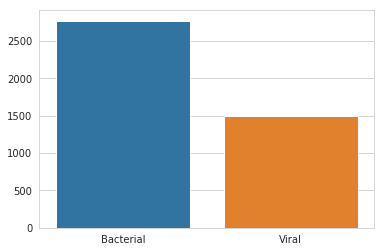

In [12]:
# Plotting the type of Dieseases
sns.set_style('whitegrid')
sns.barplot(x=['Bacterial', 'Viral'],
            y=[len(images_pneumonia_bacterial),
               len(images_pneumonia_viral)])

In [0]:
def get_image(path):
  return cv2.imread(path, 0)

def get_resized_image(path, width, height):
  im = Image.fromarray(get_image(path))
  im_w, im_h = im.size

  # Proportionally scale to be contained within canvas bounds.
  if im_w > width:
    im_h = int(width/im_w * im_h)
    im_w = width
  if im_h > height:
    im_w = int(height/im_h * im_w)
    im_h = height

  if [im_w, im_h] != list(im.size):
    im.thumbnail((im_w, im_h), Image.ANTIALIAS)

  # Return the image over a black background.    
  im_resized = Image.new('RGB', (width, height), (0, 0, 0))
  offset = ((width - im.size[0]) // 2,
            (height - im.size[1]) // 2)
  im_resized.paste(im, offset)

  return np.array(im_resized)

def plot_sample_xrays(image_set, image_label,
                      width=width//2, height=height//2,
                      rows=1, cols=3,
                      size_w=4, size_h=3):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  for idx in range(rows*cols):
    i = random.randint(0, len(image_set))
    im = get_resized_image(image_set[i], width, height)[:, :, 0]
    ax[idx%cols].imshow(im, cmap='bone')
    ax[idx%cols].axis('off')
    ax[idx%cols].set_title('Diagnosis: {}'.format(image_label))
  plt.show()

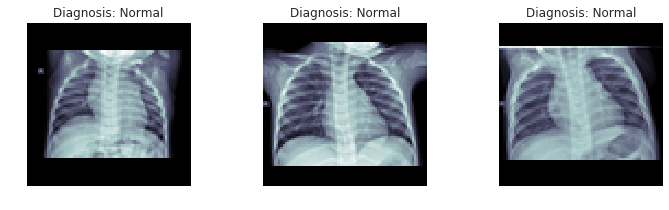

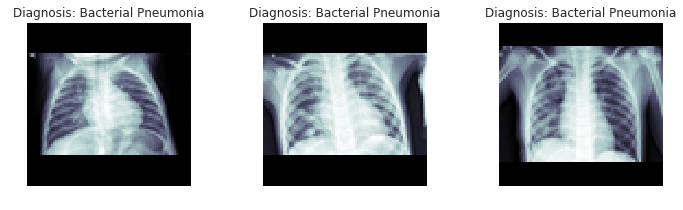

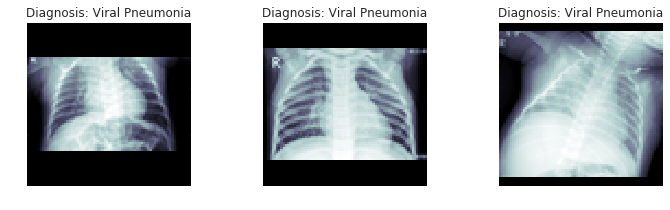

In [14]:
# Plotting Sample Images
plot_sample_xrays(images_normal, 'Normal')
plot_sample_xrays(images_pneumonia_bacterial, 'Bacterial Pneumonia')
plot_sample_xrays(images_pneumonia_viral, 'Viral Pneumonia')

In [15]:

#BASE MODEL 1
common_input = Input(shape=(height, width, 3))

# create the base pre-trained model
base_model_1 = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(height, width, 3))

base_model_1.summary()





80142336/80134624 [==============================] - 7s 0us/step


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________________________________________________

In [16]:
# ASdding Custom Layers to the Pred-Build Network 
x1 = base_model_1.output
x1 = Dropout(0.5)(x1)
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = BatchNormalization()(x1)
predictions = Dense(2, activation='sigmoid')(x1)

for layer in base_model_1.layers:
    layer.trainable = False

  
model_1 = Model(inputs=base_model_1.input, outputs=predictions)
model_1.compile(optimizer=Adam(lr=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
# Creates directory, if directory exists removes if remove parameter is True
def create_directory(directory_path, remove=False):
  if remove and os.path.exists(directory_path):
    try:
      shutil.rmtree(directory_path)
      os.mkdir(directory_path)
    except:
      print("Could not remove directory : ", directory_path)
      return False
  else:
    try:
      os.mkdir(directory_path)
    except:
      print("Could not create directory: ", directory_path)
      return False   
  return True

main_model_dir = '{}/models'.format(proj_dir)
m_dir = main_model_dir + '/' + time.strftime('%Y-%m-%d_%H-%M-%S') + '/'
ckp_path = m_dir + 'MODEL_ACC-{val_acc:.2f}-MODEL_LOSS-{val_loss:.2f}.hdf5'
create_directory(m_dir, remove=True)

# Early Stopping Parameters
checkpoint = ModelCheckpoint(ckp_path,
                             monitor='val_acc', 
                             save_weights_only=True,
                             save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=3,
                              cooldown=2,
                              min_lr=1e-12,
                              verbose=1)
early_stopping = EarlyStopping(monitor='val_acc',
                               mode='max',
                               patience=11,
                               verbose=1,
                               restore_best_weights=True)
callbacks = [checkpoint, reduce_lr, early_stopping]

In [22]:
# Fitting the model to the Data
hist = model_1.fit_generator(train_generator,
                             steps_per_epoch=len(train_generator),
                             epochs=20,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=test_generator,
                             validation_steps=len(test_generator),
                             class_weight=class_w)

Epoch 1/20
134/134 [==============================] - 201s 1s/step - loss: 0.3123 - acc: 0.8619 - val_loss: 0.3459 - val_acc: 0.8462
Epoch 2/20
134/134 [==============================] - 196s 1s/step - loss: 0.2842 - acc: 0.8738 - val_loss: 0.3535 - val_acc: 0.8510
Epoch 3/20
134/134 [==============================] - 195s 1s/step - loss: 0.2685 - acc: 0.8802 - val_loss: 0.3467 - val_acc: 0.8542
Epoch 4/20
134/134 [==============================] - 196s 1s/step - loss: 0.2456 - acc: 0.8936 - val_loss: 0.3452 - val_acc: 0.8686
Epoch 5/20
134/134 [==============================] - 195s 1s/step - loss: 0.2335 - acc: 0.8983 - val_loss: 0.3293 - val_acc: 0.8622
Epoch 6/20
134/134 [==============================] - 195s 1s/step - loss: 0.2180 - acc: 0.9080 - val_loss: 0.3361 - val_acc: 0.8702
Epoch 7/20
134/134 [==============================] - 196s 1s/step - loss: 0.2097 - acc: 0.9127 - val_loss: 0.3268 - val_acc: 0.8750
Epoch 8/20
134/134 [==============================] - 194s 1s/step - 

In [23]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

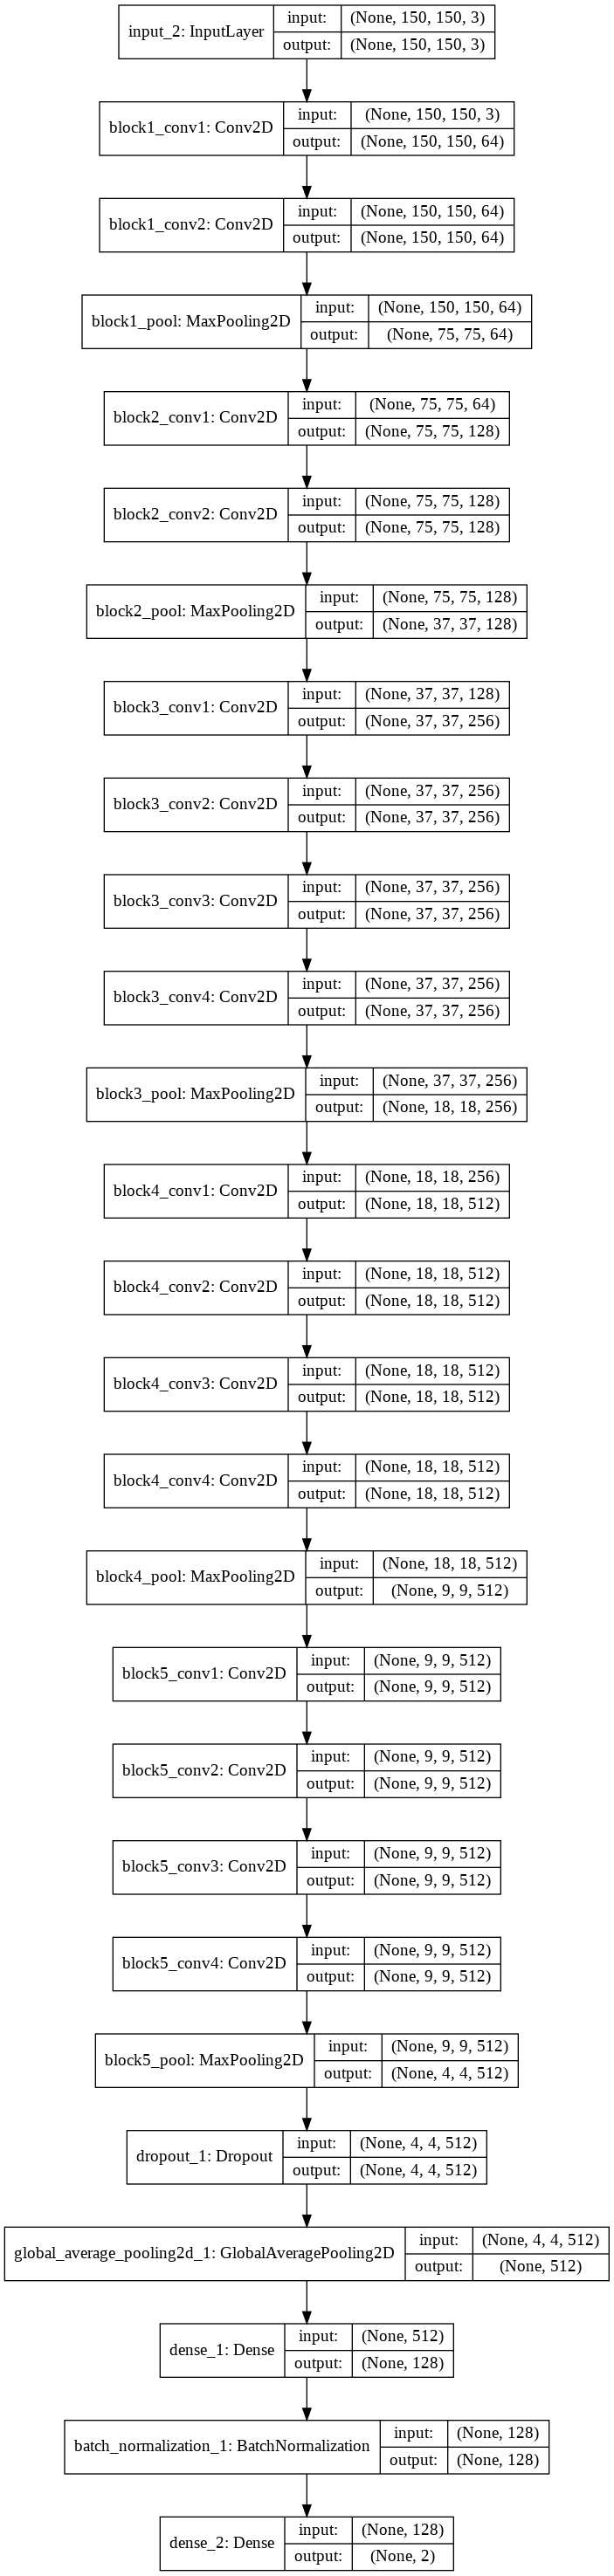

In [24]:
# Saving Model Graph

plot_model(model_1, to_file='images/Generator_model_plot.png', show_shapes=True, show_layer_names=True)

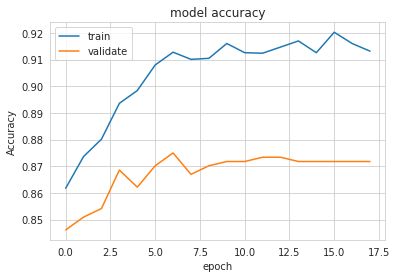

In [25]:
# Training Accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')
plt.show()

In [26]:
# Diffrent Evaluation Metrics
vl_score = model_1.predict_generator(test_generator)

classes = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes,
                            np.argmax(vl_score, axis=1),
                            target_names=classes))
print('AUC: ', roc_auc_score(test_generator.classes,
                             np.argmax(vl_score, axis=1)))

              precision    recall  f1-score   support

      Normal       0.83      0.83      0.83       234
   Pneumonia       0.90      0.90      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624

AUC:  0.8666666666666666


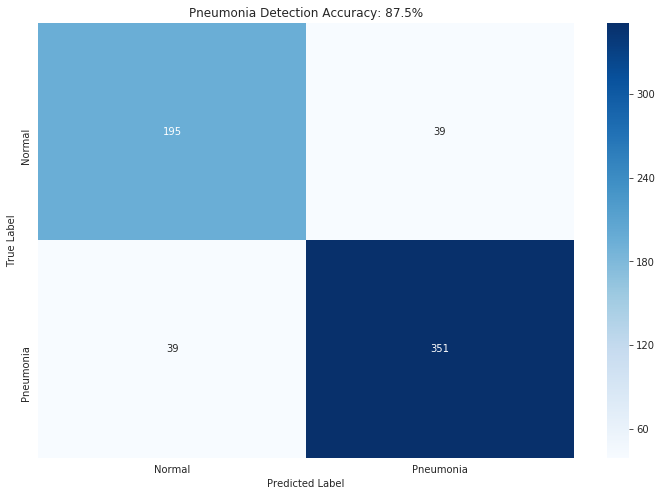

In [27]:
# plotting Confussion Accuracy
acc = accuracy_score(test_generator.classes, np.argmax(vl_score, axis=1))*100.0
cm = confusion_matrix(test_generator.classes, np.argmax(vl_score, axis=1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Pneumonia Detection Accuracy: {0:.1f}%'.format(acc))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Refrences:

Based on https://github.com/deadskull7/Pneumonia-Diagnosis-using-XRays-96-percent-Recall

Based on https://github.com/iRyanBell/chest_xray_pneumonia_vgg_attn_ensemble